In [1]:
seed=1

In [ ]:
import os

os.listdir('..')

In [2]:
from nasbench import api

nasbench_path = '../data/nasbench_only108.tfrecord'
nb = api.NASBench(nasbench_path)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 33 seconds


In [3]:
import torch
from info_nas.datasets.arch2vec_dataset import get_labeled_unlabeled_datasets

#torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# device = None otherwise the dataset is save to the cuda as a whole
labeled, unlabeled = get_labeled_unlabeled_datasets(nb, device=device, seed=seed)

Loading nasbench dataset (arch2vec) from ../data/nb_dataset.json
Processing labeled nets for the training set...
Loading labeled dataset from ../data/train_labeled.pt.
Processing labeled nets for the validation set...
Loading labeled dataset from ../data/valid_labeled.pt.


## Test dataset shapes

In [11]:
for i in range(len(labeled['valid_io']['inputs'])):
    if i not in labeled['valid_io']['inputs']:
        raise ValueError()
        
    assert (sum(labeled['train_io']['inputs'] == i)) == 4

In [29]:
[l.shape for l in labeled['train_io'].values() if not isinstance(l, int)]

[(4000,), torch.Size([4000, 128, 32, 32]), torch.Size([4000, 512])]

In [38]:
# 7 GB per 4000 nets
labeled['train_io']['outputs'].element_size() * 4000 * 512 / 1024 / 1024 / 1024 * 1000

7.62939453125

In [7]:
[l.shape for l in labeled['train_net']]

[torch.Size([4000, 7, 7]), torch.Size([4000, 7, 5])]

In [8]:
unlabeled.keys()

dict_keys(['train', 'n_train', 'val', 'n_val'])

In [9]:
unlabeled['train'][1][0].shape, unlabeled['train'][2][0].shape

(torch.Size([7, 7]), torch.Size([7, 5]))

In [10]:
len(unlabeled['train'][1])

381261

## Test model shapes

In [5]:
from arch2vec.extensions.get_nasbench101_model import get_arch2vec_model

model, opt = get_arch2vec_model()

In [11]:
from arch2vec.extensions.get_nasbench101_model import get_nasbench_datasets

nb_dataset = get_nasbench_datasets('../data/nb_dataset.json', batch_size=None, seed=1)

In [23]:
#model.train()
model.eval()

batch_adj, batch_ops = nb_dataset['train'][1][:32], nb_dataset['train'][2][:32]

mu, logvar = model._encoder(batch_ops, batch_adj)
z = model.reparameterize(mu, logvar)

In [25]:
print(f"mu shape: {mu.shape}, logvar shape: {logvar.shape}, z shape: {z.shape}")

mu shape: torch.Size([32, 7, 16]), logvar shape: torch.Size([32, 7, 16]), z shape: torch.Size([32, 7, 16])


In [34]:
import torch.nn as nn

m = nn.Sequential(
    nn.Flatten(),
    nn.Linear(z.shape[1] * z.shape[2], 5),
    nn.ReLU()
)
m(z).shape

torch.Size([32, 5])

In [43]:
# test unsqueeze and channels

conv = nn.Conv2d(32, 8, 1, padding=0)
conv(mu.unsqueeze(0)).shape

torch.Size([1, 8, 7, 16])

In [74]:
# repeat and concat
repeated = torch.Tensor([3]).repeat(mu.shape[0], mu.shape[1], 1)
print(repeated.shape)

torch.cat([mu, repeated], axis=-1).shape

torch.Size([32, 7, 1])


torch.Size([32, 7, 17])

## Extended models

In [4]:
from arch2vec.extensions.get_nasbench101_model import get_arch2vec_model
from arch2vec.extensions.get_nasbench101_model import get_nasbench_datasets

model, opt = get_arch2vec_model(device=device)

In [5]:
print(labeled['train']['dataset'].shape)
print(labeled['train']['inputs'].shape)
print(labeled['train']['outputs'].shape)

torch.Size([1000, 3, 32, 32])
torch.Size([4000])
torch.Size([4000, 512, 8, 8])


In [6]:
from info_nas.models.io_model import ConcatConvModel

extended_model = ConcatConvModel(model, 128, 512).to(device)

In [18]:
in_batch = labeled['train_io']['inputs'][:32]
out_batch = labeled['train_io']['outputs'][:32]

batch_adj, batch_ops = labeled['train_net'][0][:32], labeled['train_net'][1][:32]

In [20]:
ops_recon, adj_recon, mu, logvar, _, outputs = extended_model(batch_ops.to(device), batch_adj.to(device), in_batch.to(device))

In [21]:
outputs.shape

torch.Size([32, 512, 8, 8])

### Just some tests

In [ ]:
_,_,_,_,z = model(batch_ops.to(device), batch_adj.to(device))
z = extended_model.process_z(z)
z = z.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, in_batch.shape[2], in_batch.shape[3])
z.shape

In [ ]:
torch.cat([z, in_batch], dim=1).shape

## Training

In [7]:
import torch
from info_nas.trainer import train

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
else:
    device = None
    
model = train(labeled, unlabeled, nb, checkpoint_path='.', device=device,
              use_reference_model=True, batch_len_labeled=7)

/media/win_hdd/Gabi/Code/mff/ML/DP/code/info-nas/info_nas/datasets/io/semi_dataset.py:140: UserWarning: The number of labeled nets is less than the batch size (4 vs 32).
  warnings.warn(f"The number of labeled nets is less than the batch size ({n_labeled_orig} vs {batch_size}).")


epoch 0: batch 0 / 12040: 
	 labeled: total: 3.5410568714141846, unlabeled: 3.342668056488037, labeled: 0.19838890433311462
	 unlabeled: 
	 reference: total: 3.843514919281006, unlabeled: 3.843514919281006
	 labeled batches: 1, unlabeled batches: 0
epoch 0: batch 1000 / 12040: 
	 labeled: total: 1.142551836490631, unlabeled: 0.9324217414855958, labeled: 0.21013009786605835
	 unlabeled: total: 0.7051143738777126, unlabeled: 0.7051143738777126
	 reference: total: 0.726556360602498, unlabeled: 0.726556360602498
	 labeled batches: 125, unlabeled batches: 876
epoch 0: batch 2000 / 12040: 
	 labeled: total: 1.142551836490631, unlabeled: 0.9324217414855958, labeled: 0.21013009786605835
	 unlabeled: total: 0.5890314610146764, unlabeled: 0.5890314610146764
	 reference: total: 0.6016492928968913, unlabeled: 0.6016492928968913
	 labeled batches: 125, unlabeled batches: 1876
epoch 0: batch 3000 / 12040: 
	 labeled: total: 1.142551836490631, unlabeled: 0.9324217414855958, labeled: 0.210130097866058

KeyboardInterrupt: 

In [11]:
model[1]

{'labeled': {},
 'unlabeled': {'validity': [0.513,
   0.4926,
   0.4919,
   0.4829,
   0.4965,
   0.4849,
   0.4856,
   0.4995],
  'uniqueness': [0.9908382066257488,
   0.9894437677608822,
   0.9873958121549352,
   0.9913025471091503,
   0.9905337361510765,
   0.9882449989668215,
   0.9903212520572687,
   0.9901901901882079],
  'acc_ops_val': [74.41879983091681,
   85.6906997995837,
   91.79245175758614,
   92.85074018349628,
   92.63005296267433,
   94.47641392375512,
   96.7473037207743,
   96.24696663668678],
  'mean_corr_adj_val': [tensor(93.1906, device='cuda:0'),
   tensor(92.5475, device='cuda:0'),
   tensor(95.0476, device='cuda:0'),
   tensor(95.1042, device='cuda:0'),
   tensor(94.6378, device='cuda:0'),
   tensor(95.0807, device='cuda:0'),
   tensor(95.5706, device='cuda:0'),
   tensor(94.2557, device='cuda:0')],
  'mean_fal_pos_adj_val': [tensor(13.2116, device='cuda:0'),
   tensor(9.5474, device='cuda:0'),
   tensor(8.7598, device='cuda:0'),
   tensor(10.3409, device='cuda

In [8]:
labeled_2 = labeled.copy()

imax = labeled_2['train_io']['inputs'].max()
labeled_2['train_io']['inputs'] /= imax

omax = labeled_2['train_io']['outputs'].max()
labeled_2['train_io']['outputs'] /= omax

print(labeled_2['train_io']['inputs'].max(), labeled_2['train_io']['outputs'].max())

RuntimeError: result type Float can't be cast to the desired output type Long

In [8]:
len(labeled['train_io']['inputs'])

4000

<IPython.core.display.Javascript object>


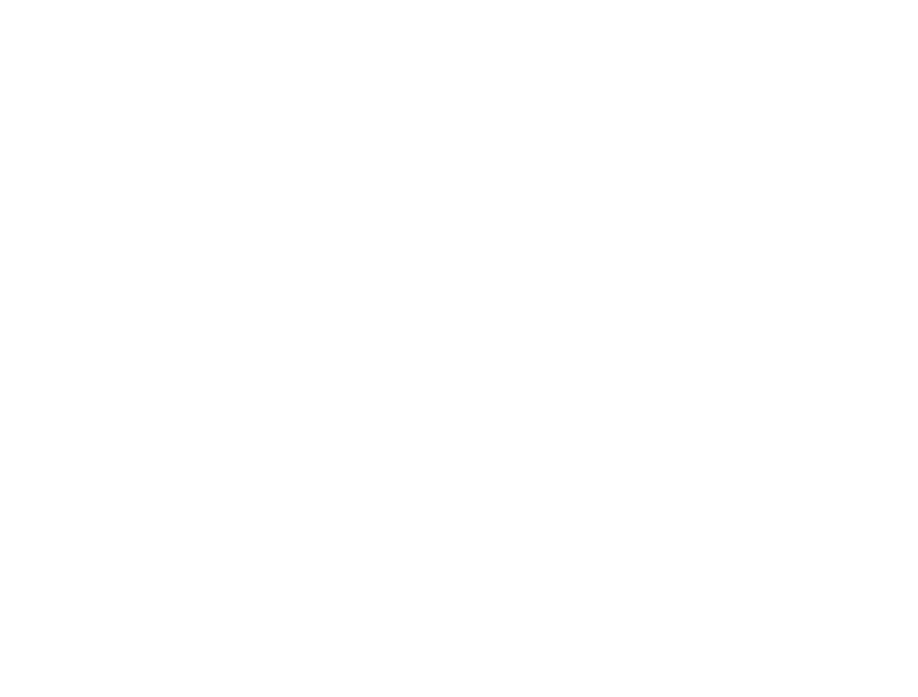

In [44]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()
plt.imshow(labeled_2['train_io']['outputs'], cmap='hot', interpolation='nearest')
plt.show()